##melanoma_segmentation

In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!ls 'drive/My Drive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Final Project'   Other


In [ ]:
# 1. Import Required Modules

import os
import glob
import keras
import random
import numpy as np
import tensorflow as tf
from keras.layers import *
import keras.backend as k
from keras.models import *
from keras.optimizers import *
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow, imsave
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
# 2. Define Train & Test Path (Images + Mask Path for Train and Test Stages)

TRAIN_IMAGE_PATH = '/content/drive/My Drive/Other/melanoma_segmentation/dataset/train'
TRAIN_MASK_PATH = '/content/drive/My Drive/Other/melanoma_segmentation/dataset/train mask'
TEST_IMAGE_PATH = '/content/drive/My Drive/Other/melanoma_segmentation/dataset/test'
TEST_MASK_PATH = '/content/drive/My Drive/Other/melanoma_segmentation/dataset/test mask'

In [ ]:
# 3. Initialize Images and Mask Size

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 64, 64, 3

In [ ]:
# 4. Define Pre_Processing Function (Region of Interest Extraction _ ROI)

Train_Mask_List = sorted(next(os.walk(TRAIN_MASK_PATH))[2])
Test_Mask_List = sorted(next(os.walk(TEST_MASK_PATH))[2])

def Data_Proprocessing_Train():

    Init_Image = np.zeros((len(Train_Mask_List), 192, 256, 3), dtype = np.uint8)
    Init_Mask = np.zeros((len(Train_Mask_List), 192, 256), dtype = np.bool)
    Train_X = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    Train_Y = np.zeros((len(Train_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

    n = 0

    for mask_path in glob.glob('{}/*.jpg'.format(TRAIN_MASK_PATH)):

        base = os.path.basename(mask_path)
        image_ID, ext = os.path.splitext(base)
        image_path = '{}/{}.jpg'.format(TRAIN_IMAGE_PATH, image_ID)
        mask = imread(mask_path)
        image = imread(image_path)

        y_coord, x_coord = np.where(mask == 255)

        y_min = min(y_coord)
        y_max = max(y_coord)
        x_min = min(x_coord)
        x_max = max(x_coord)

        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

        Train_X[n] = resize(cropped_image[:,:,:IMG_CHANNELS],
               (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True)

        Train_Y[n] = np.expand_dims(resize(cropped_mask,
               (IMG_HEIGHT, IMG_WIDTH),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True), axis = -1)

        Init_Image[n] = image
        Init_Mask[n] = mask

        n+=1

    return Train_X, Train_Y, Init_Image, Init_Mask

Train_Inputs, Train_Masks, Init_Image, Init_Mask = Data_Proprocessing_Train()


def Data_Proprocessing_Test():


    Test_X = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
    Test_Y = np.zeros((len(Test_Mask_List), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

    n = 0

    for mask_path in glob.glob('{}/*.jpg'.format(TEST_MASK_PATH)):

        base = os.path.basename(mask_path)
        image_ID, ext = os.path.splitext(base)
        image_path = '{}/{}.jpg'.format(TEST_IMAGE_PATH, image_ID)
        mask = imread(mask_path)
        image = imread(image_path)

        y_coord, x_coord = np.where(mask == 255)

        y_min = min(y_coord)
        y_max = max(y_coord)
        x_min = min(x_coord)
        x_max = max(x_coord)

        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]

        Test_X[n] = resize(cropped_image[:,:,:IMG_CHANNELS],
               (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True)

        Test_Y[n] = np.expand_dims(resize(cropped_mask,
               (IMG_HEIGHT, IMG_WIDTH),
               mode = 'constant',
               anti_aliasing=True,
               preserve_range=True), axis = -1)


        n+=1

    return Test_X, Test_Y

Test_Inputs, Test_Masks = Data_Proprocessing_Test()



Original_Image


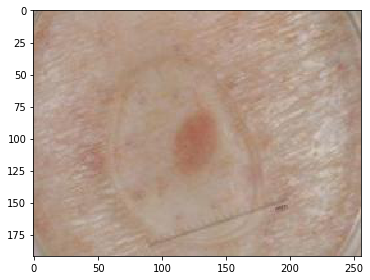

Original_Mask


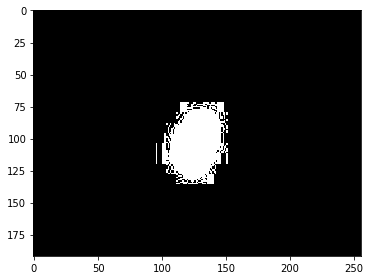

Region_of_Interest_Image


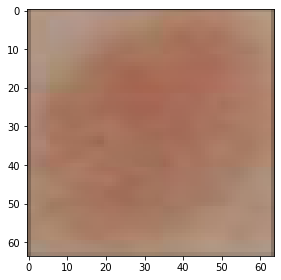

Region_of_Interest_Mask


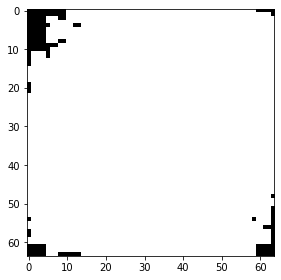

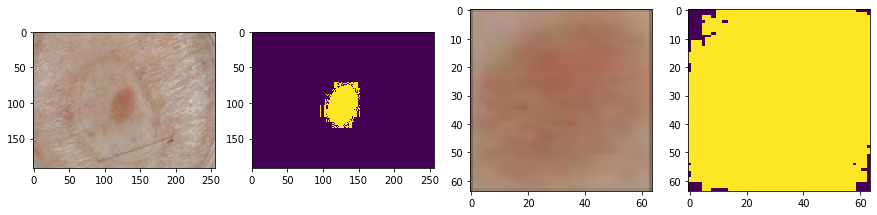

In [ ]:
 # 4.1. Show The Results in Preprocessing Stage

print('Original_Image')
imshow(Init_Image[0])
plt.show()

print('Original_Mask')
imshow(Init_Mask[0])
plt.show()

print('Region_of_Interest_Image')
imshow(Train_Inputs[0])
plt.show()

print('Region_of_Interest_Mask')
imshow(np.squeeze(Train_Masks[0]))
plt.show()

rows = 1
columns = 4
Figure = plt.figure(figsize=(15,15))
Image_List = [Init_Image[0], Init_Mask[0], Train_Inputs[0], Train_Masks[0]]

for i in range(1, rows*columns + 1):

  Image = Image_List[i-1]
  Sub_Plot_Image = Figure.add_subplot(rows, columns, i)
  Sub_Plot_Image.imshow(np.squeeze(Image))
plt.show()


In [ ]:
# 5. Implementation of U_NET Model for Semantic Segmentation

def U_Net_Segmentation(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):

    inputs = Input(input_size)
    n = Lambda(lambda x:x/255)(inputs)


    c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(n)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)


    c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)


    c3 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)


    c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)


    c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c5)



    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c6)


    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c8)


    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',
                padding='same')(c9)

    outputs = Conv2D(1,(1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=[Mean_IOU_Evaluator])
    model.summary()
    return model


In [ ]:
# 6. Define U_NET Model Evaluator (Intersection Over Union _ IOU)

def Mean_IOU_Evaluator(y_true, y_pred):

    prec = []

    for t in np.arange(0.5, 1, 0.05):

        y_pred_ = tf.to_int32(y_pred>t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        k.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return k.mean(k.stack(prec), axis = 0)

model = U_Net_Segmentation()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 16)   448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
# 7. Show The Results per Epoch

class loss_history(keras.callbacks.Callback):

    def __init__ (self, x=4):
        self.x = x

    def on_epoch_begin(self, epoch, logs={}):

        imshow(Train_Inputs[self.x])
        plt.show()

        imshow(np.squeeze(Train_Masks[self.x]))
        plt.show()

        preds_train = self.model.predict(np.expand_dims(Train_Inputs[self.x], axis = 0))
        imshow(np.squeeze(preds_train[0]))
        plt.show()


imageset = 'BCC'
backbone = 'UNET'
version = 'v1.0'
model_h5 = 'model-{imageset}-{backbone}-{version}.h5'.format(imageset=imageset,
                  backbone = backbone, version = version)
model_h5_checkpoint = '{model_h5}.checkpoint'.format(model_h5=model_h5)

earlystopper = EarlyStopping(patience=7, verbose=1)
checkpointer = ModelCheckpoint(model_h5_checkpoint, verbose = 1, save_best_only=True)

Train on 45 samples, validate on 5 samples
Epoch 1/50


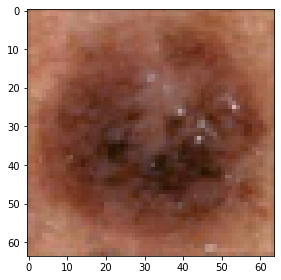

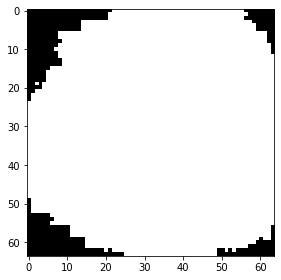

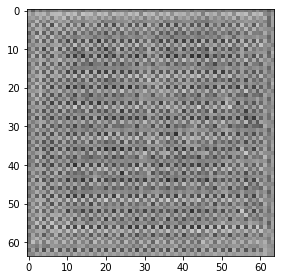

45/45 [==============================] - 8s 176ms/step - loss: 0.3790 - Mean_IOU_Evaluator: 0.3577 - val_loss: 0.3618 - val_Mean_IOU_Evaluator: 0.4469

Epoch 00001: val_loss improved from inf to 0.36184, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 2/50


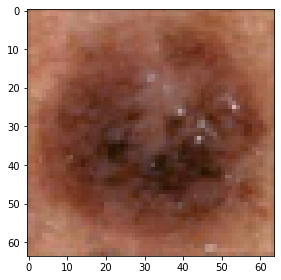

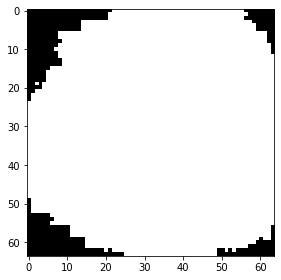

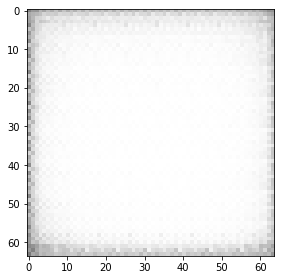

45/45 [==============================] - 4s 90ms/step - loss: 0.2123 - Mean_IOU_Evaluator: 0.4856 - val_loss: 0.2417 - val_Mean_IOU_Evaluator: 0.5253

Epoch 00002: val_loss improved from 0.36184 to 0.24172, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 3/50


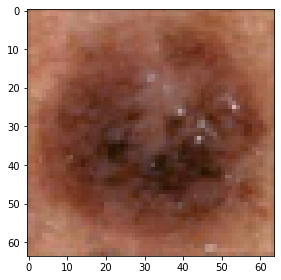

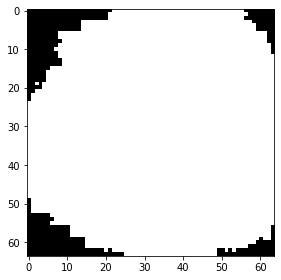

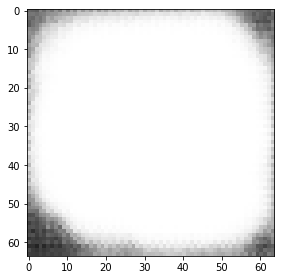

45/45 [==============================] - 4s 90ms/step - loss: 0.1972 - Mean_IOU_Evaluator: 0.5491 - val_loss: 0.2630 - val_Mean_IOU_Evaluator: 0.5670

Epoch 00003: val_loss did not improve from 0.24172
Epoch 4/50


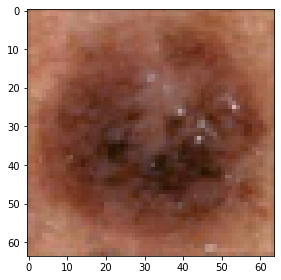

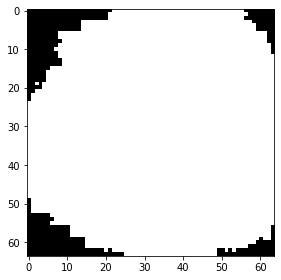

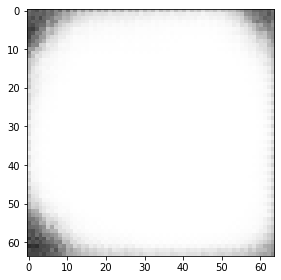

45/45 [==============================] - 4s 91ms/step - loss: 0.1696 - Mean_IOU_Evaluator: 0.5811 - val_loss: 0.2216 - val_Mean_IOU_Evaluator: 0.5938

Epoch 00004: val_loss improved from 0.24172 to 0.22156, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 5/50


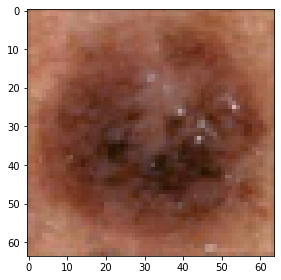

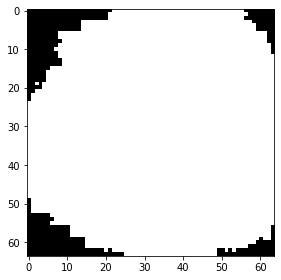

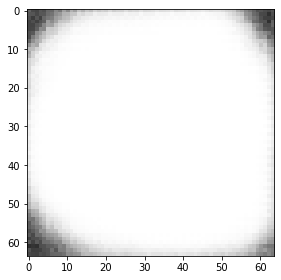

45/45 [==============================] - 4s 92ms/step - loss: 0.1546 - Mean_IOU_Evaluator: 0.6059 - val_loss: 0.3919 - val_Mean_IOU_Evaluator: 0.6138

Epoch 00005: val_loss did not improve from 0.22156
Epoch 6/50


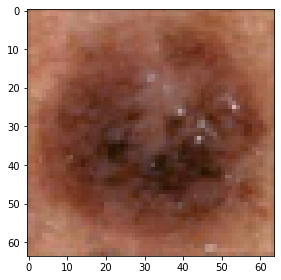

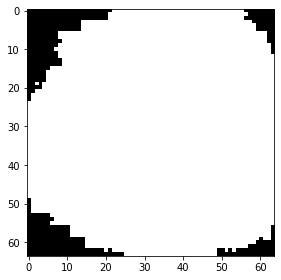

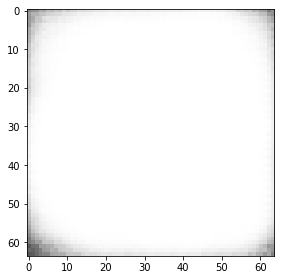

45/45 [==============================] - 4s 89ms/step - loss: 0.1572 - Mean_IOU_Evaluator: 0.6197 - val_loss: 0.1976 - val_Mean_IOU_Evaluator: 0.6276

Epoch 00006: val_loss improved from 0.22156 to 0.19765, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 7/50


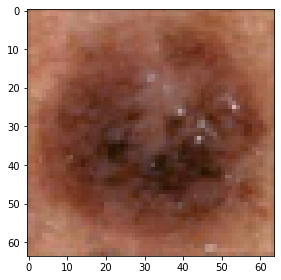

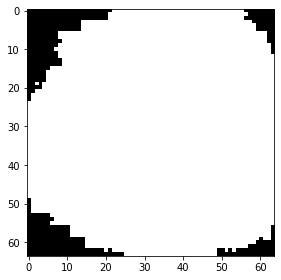

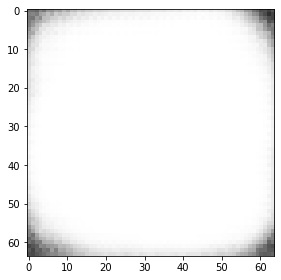

45/45 [==============================] - 4s 88ms/step - loss: 0.1778 - Mean_IOU_Evaluator: 0.6319 - val_loss: 0.2227 - val_Mean_IOU_Evaluator: 0.6360

Epoch 00007: val_loss did not improve from 0.19765
Epoch 8/50


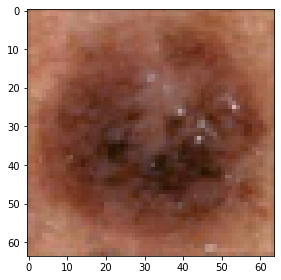

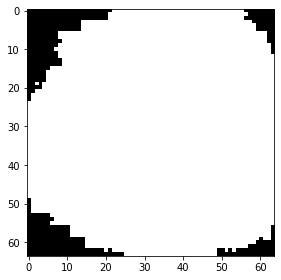

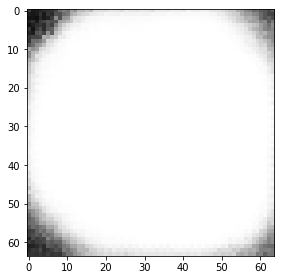

45/45 [==============================] - 4s 86ms/step - loss: 0.1591 - Mean_IOU_Evaluator: 0.6406 - val_loss: 0.2934 - val_Mean_IOU_Evaluator: 0.6434

Epoch 00008: val_loss did not improve from 0.19765
Epoch 9/50


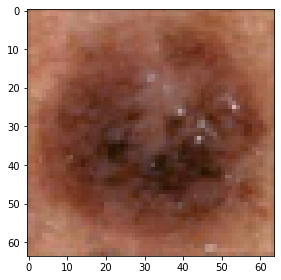

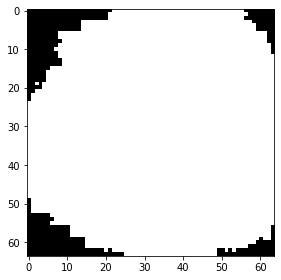

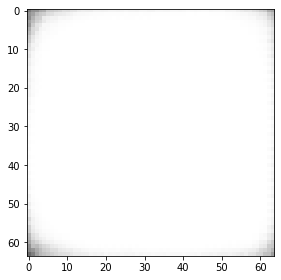

45/45 [==============================] - 4s 86ms/step - loss: 0.1523 - Mean_IOU_Evaluator: 0.6471 - val_loss: 0.1682 - val_Mean_IOU_Evaluator: 0.6509

Epoch 00009: val_loss improved from 0.19765 to 0.16817, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 10/50


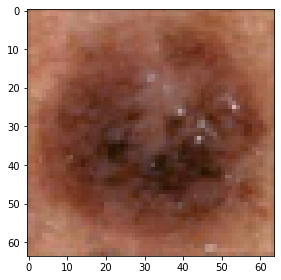

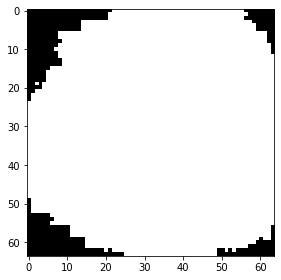

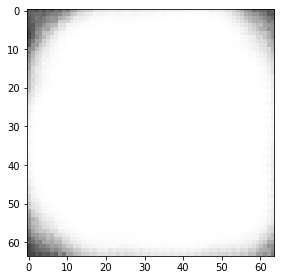

45/45 [==============================] - 4s 86ms/step - loss: 0.1305 - Mean_IOU_Evaluator: 0.6554 - val_loss: 0.1551 - val_Mean_IOU_Evaluator: 0.6603

Epoch 00010: val_loss improved from 0.16817 to 0.15507, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 11/50


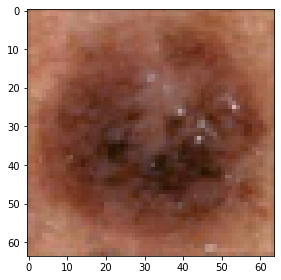

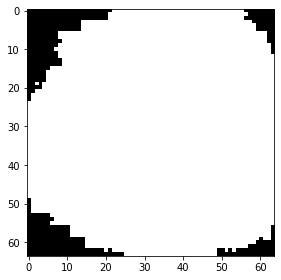

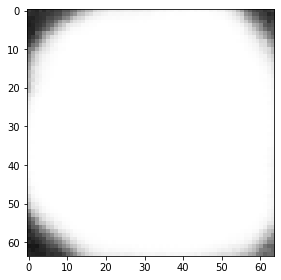

45/45 [==============================] - 4s 87ms/step - loss: 0.1358 - Mean_IOU_Evaluator: 0.6644 - val_loss: 0.1552 - val_Mean_IOU_Evaluator: 0.6677

Epoch 00011: val_loss did not improve from 0.15507
Epoch 12/50


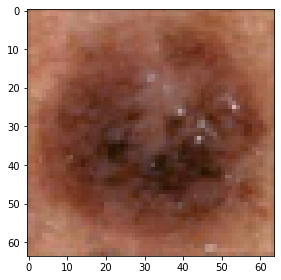

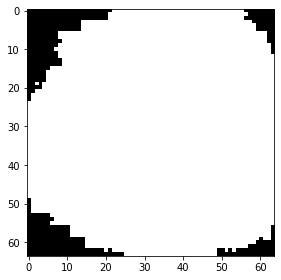

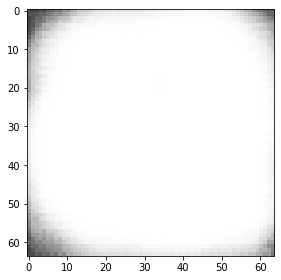

45/45 [==============================] - 4s 87ms/step - loss: 0.1238 - Mean_IOU_Evaluator: 0.6705 - val_loss: 0.1538 - val_Mean_IOU_Evaluator: 0.6743

Epoch 00012: val_loss improved from 0.15507 to 0.15377, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 13/50


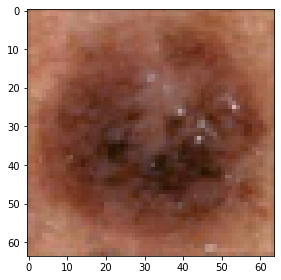

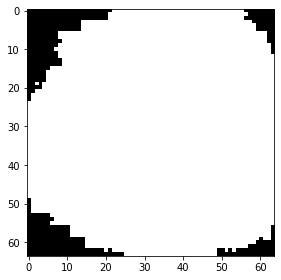

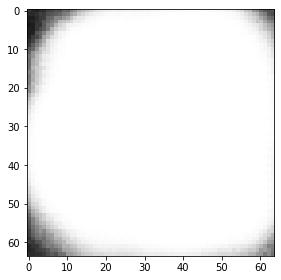

45/45 [==============================] - 4s 88ms/step - loss: 0.1167 - Mean_IOU_Evaluator: 0.6780 - val_loss: 0.1323 - val_Mean_IOU_Evaluator: 0.6813

Epoch 00013: val_loss improved from 0.15377 to 0.13231, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 14/50


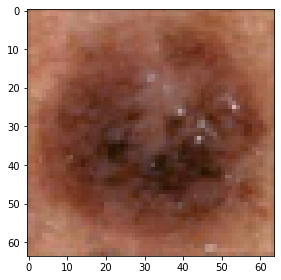

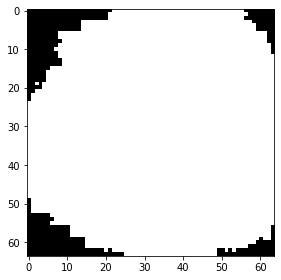

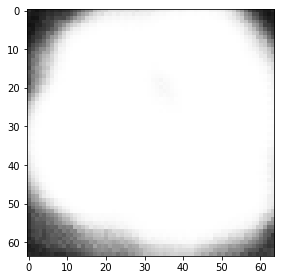

45/45 [==============================] - 4s 86ms/step - loss: 0.1214 - Mean_IOU_Evaluator: 0.6837 - val_loss: 0.1308 - val_Mean_IOU_Evaluator: 0.6865

Epoch 00014: val_loss improved from 0.13231 to 0.13079, saving model to model-BCC-UNET-v1.0.h5.checkpoint
Epoch 15/50


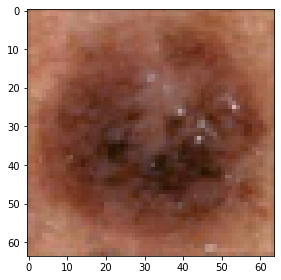

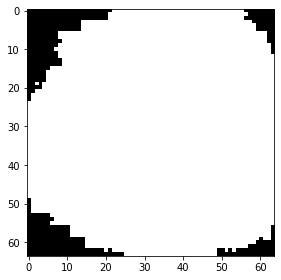

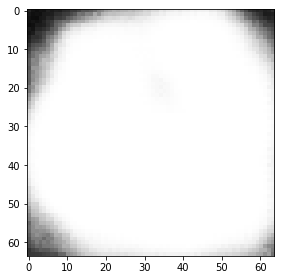

45/45 [==============================] - 4s 92ms/step - loss: 0.1148 - Mean_IOU_Evaluator: 0.6891 - val_loss: 0.1461 - val_Mean_IOU_Evaluator: 0.6919

Epoch 00015: val_loss did not improve from 0.13079
Epoch 16/50


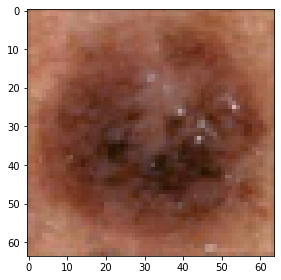

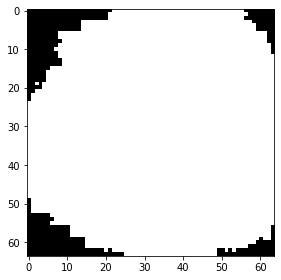

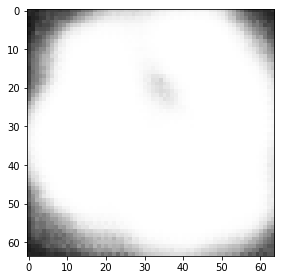

45/45 [==============================] - 4s 86ms/step - loss: 0.1162 - Mean_IOU_Evaluator: 0.6939 - val_loss: 0.2050 - val_Mean_IOU_Evaluator: 0.6960

Epoch 00016: val_loss did not improve from 0.13079
Epoch 17/50


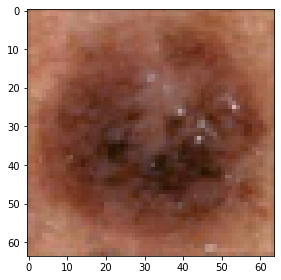

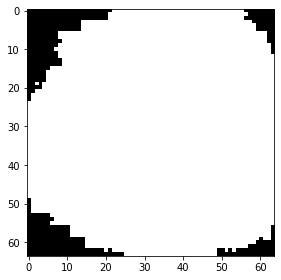

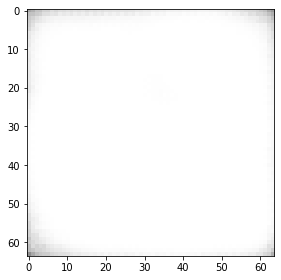

45/45 [==============================] - 4s 86ms/step - loss: 0.1195 - Mean_IOU_Evaluator: 0.6975 - val_loss: 0.1380 - val_Mean_IOU_Evaluator: 0.6996

Epoch 00017: val_loss did not improve from 0.13079
Epoch 18/50


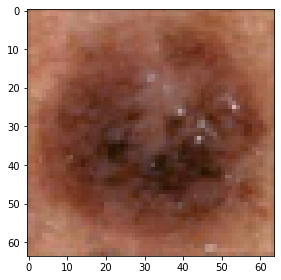

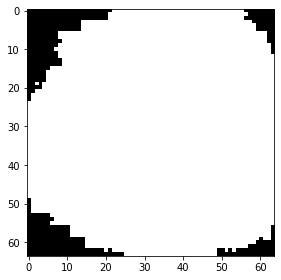

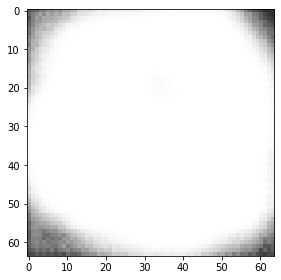

45/45 [==============================] - 4s 86ms/step - loss: 0.1020 - Mean_IOU_Evaluator: 0.7016 - val_loss: 0.1443 - val_Mean_IOU_Evaluator: 0.7042

Epoch 00018: val_loss did not improve from 0.13079
Epoch 19/50


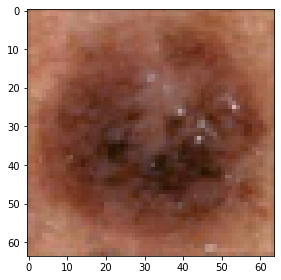

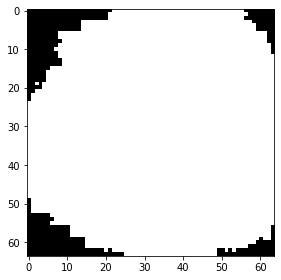

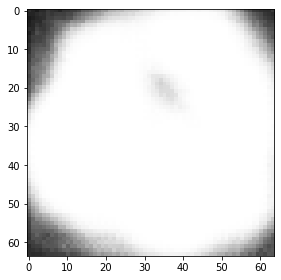

45/45 [==============================] - 4s 86ms/step - loss: 0.0960 - Mean_IOU_Evaluator: 0.7065 - val_loss: 0.1980 - val_Mean_IOU_Evaluator: 0.7087

Epoch 00019: val_loss did not improve from 0.13079
Epoch 20/50


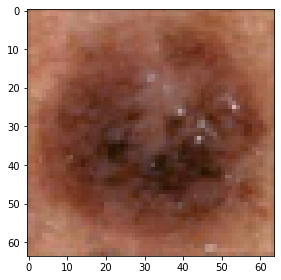

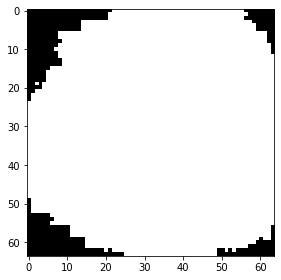

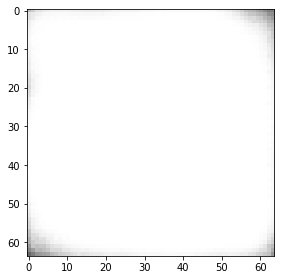

45/45 [==============================] - 4s 85ms/step - loss: 0.1015 - Mean_IOU_Evaluator: 0.7107 - val_loss: 0.1604 - val_Mean_IOU_Evaluator: 0.7124

Epoch 00020: val_loss did not improve from 0.13079
Epoch 21/50


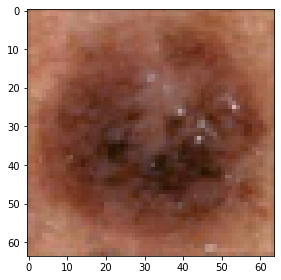

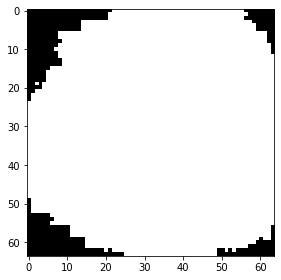

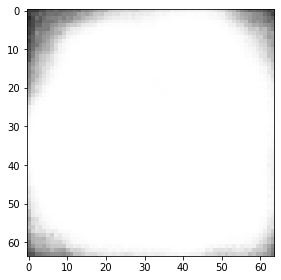

45/45 [==============================] - 4s 85ms/step - loss: 0.1271 - Mean_IOU_Evaluator: 0.7139 - val_loss: 0.1894 - val_Mean_IOU_Evaluator: 0.7141

Epoch 00021: val_loss did not improve from 0.13079
Epoch 00021: early stopping


In [ ]:
# 8. Train U_NET Model using Training Samples

results = model.fit(Train_Inputs, Train_Masks,
                    validation_split=0.1,
                    batch_size=2,
                    epochs=50,
                    callbacks=[earlystopper, checkpointer, loss_history()])

In [ ]:
# 9. U_NET Model Evaluation using Test Samples

preds_train = model.predict(Train_Inputs, verbose=1)
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_test = model.predict(Test_Inputs, verbose=1)
preds_test_t = (preds_test>0.5).astype(np.uint8)


2/2 [==============================] - 0s 15ms/step


4
Train_Image


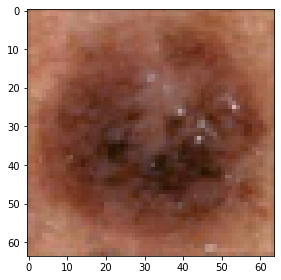

Train_Mask


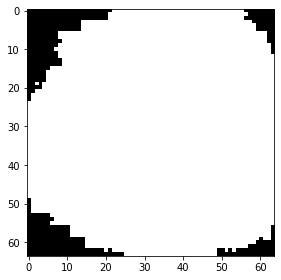

Segmented_Image


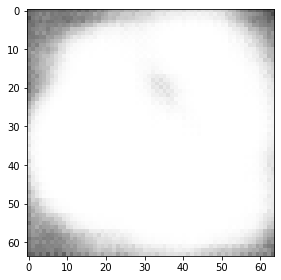

1
Test_Image


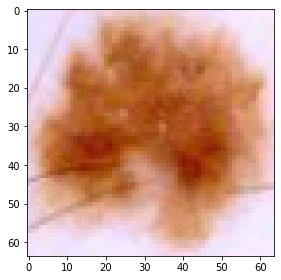

Test_Mask


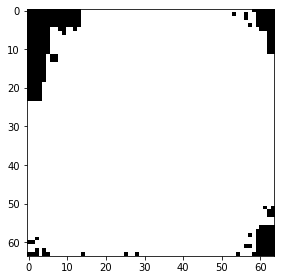

Segmented_Test_Mask


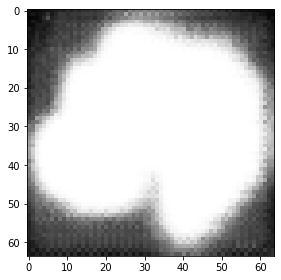

In [ ]:
# 10. Show Final Results (Segmented Images)

ix = random.randint(0, len(Train_Inputs)-1)

print(ix)

print('Train_Image')
imshow(Train_Inputs[ix])
plt.show()

print('Train_Mask')
imshow(np.squeeze(Train_Masks[ix]))
plt.show()

print('Segmented_Image')
imshow(np.squeeze(preds_train[ix]))
plt.show()


iix = random.randint(0,1)
print(iix)

print('Test_Image')
imshow(Test_Inputs[iix])
plt.show()

print('Test_Mask')
imshow(np.squeeze(Test_Masks[iix]))
plt.show()

print('Segmented_Test_Mask')
imshow(np.squeeze(preds_test[iix]))
plt.show()



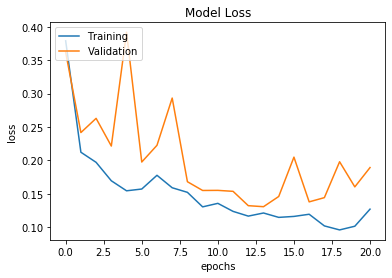

In [ ]:
# 11. Show Loss and IOU Plots
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training','Validation'], loc = 'upper left')
plt.show()


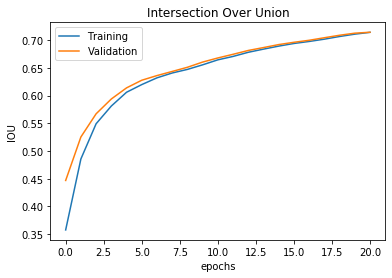

In [ ]:
# 11.1. Summarize History for IOU

plt.plot(results.history['Mean_IOU_Evaluator'])
plt.plot(results.history['val_Mean_IOU_Evaluator'])
plt.title('Intersection Over Union')
plt.ylabel('IOU')
plt.xlabel('epochs')
plt.legend(['Training','Validation'], loc = 'upper left')
plt.show()
